# Cargamos Librerías

In [40]:
import pandas as pd
import warnings
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import utils as eda
import numpy as np

def warn(*args, **kwargs):
    pass
warnings.warn = warn
#warnings.filterwarnings("ignore", category=FutureWarning)

# Cargamos los Dataset

In [41]:
movies = pd.read_csv("../data/raw/rotten_tomatoes_movies.csv")

In [42]:
eda.analisis(movies)

Variables numéricas: ['runtime', 'tomatometer_rating', 'tomatometer_count', 'audience_rating', 'audience_count', 'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count']
Variables no numéricas: ['rotten_tomatoes_link', 'movie_title', 'movie_info', 'critics_consensus', 'content_rating', 'genres', 'directors', 'authors', 'actors', 'original_release_date', 'streaming_release_date', 'production_company', 'tomatometer_status', 'audience_status']

Shape del dataset: (17712, 22)

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17712 entries, 0 to 17711
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   rotten_tomatoes_link              17712 non-null  object 
 1   movie_title                       17712 non-null  object 
 2   movie_info                        17391 non-null  object 
 3   critics_consensus    

El dataset de películas, *movies*, contiene 22 variables: 8 variable numéricas y 14 variables categóricas.

- rotten_tomatoes_link: Identificador o enlace único de la película en Rotten Tomatoes.
- movie_title: Título de la película.
- movie_info: Información general (sinopsis, detalles adicionales).
- critics_consensus: Resumen del consenso de los críticos.
- content_rating: Clasificación de la película (PG, R, etc.).
- genres: Género(s) de la película.
- directors: Director(es) de la película.
- authors: Críticos o autores asociados.
- actors: Actores principales.
- original_release_date: Fecha de estreno original.
- streaming_release_date: Fecha de estreno en plataformas digitales.
- runtime: Duración de la película (minutos).
- production_company: Productora responsable.
- tomatometer_status: Estado en el Tomatometer (Certified Fresh, Fresh, Rotten).
- tomatometer_rating: Puntuación promedio de críticos.
- tomatometer_count: Número de críticas registradas.
- audience_status: Estado de la audiencia (Upright/Spilled).
- audience_rating: Puntuación promedio de la audiencia.
- audience_count: Número de valoraciones de la audiencia.
- tomatometer_top_critics_count: Número de críticas de críticos top.
- tomatometer_fresh_critics_count: Cantidad de críticas positivas.
- tomatometer_rotten_critics_count: Cantidad de críticas negativas.


## Eliminar Duplicados

Verificamos si existen duplicados.

In [43]:
movies.drop_duplicates()

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,...,Waner Bros.,Fresh,67.0,24.0,Spilled,53.0,14684.0,2,16,8
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,...,Criterion Collection,Certified-Fresh,100.0,54.0,Upright,97.0,105386.0,6,54,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,...,Disney,Fresh,89.0,27.0,Upright,74.0,68918.0,5,24,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17707,m/zoot_suit,Zoot Suit,Mexican-American gangster Henry Reyna (Daniel ...,NaN,R,"Drama, Musical & Performing Arts",Luis Valdez,Luis Valdez,"Daniel Valdez, Edward James Olmos, Charles Aid...",1981-10-02,...,MCA Universal Home Video,Rotten,56.0,9.0,Upright,74.0,1195.0,2,5,4
17708,m/zootopia,Zootopia,From the largest elephant to the smallest shre...,The brilliantly well-rounded Zootopia offers a...,PG,"Action & Adventure, Animation, Comedy","Byron Howard, Rich Moore, Jared Bush","Jared Bush, Phil Johnston","J.K. Simmons, Kristen Bell, Octavia Spencer, A...",2016-03-04,...,Walt Disney Animation Studios,Certified-Fresh,98.0,291.0,Upright,92.0,101511.0,50,285,7
17709,m/zorba_the_greek,Zorba the Greek,Traveling to inspect an abandoned mine his fat...,NaN,NR,"Action & Adventure, Art House & International,...",NaN,NaN,"Anthony Quinn, Alan Bates, Irene Papas, Lila K...",1964-12-17,...,Fox,Fresh,80.0,10.0,Upright,86.0,7146.0,0,8,2
17710,m/zulu,Zulu,"In 1879, the Zulu nation hands colonial Britis...",Zulu patiently establishes a cast of colorful ...,PG,"Classics, Drama","Cy Endfield, Cyril Endfield","Cy Endfield, John Prebble","Stanley Baker, Jack Hawkins, Ulla Jacobsson, J...",1964-06-17,...,Paramount Pictures,Fresh,96.0,23.0,Upright,91.0,30193.0,6,22,1


No hay filas duplicadas en el dataset *movies*.

## Crear Listas
Para poder hacer un mejor análisis de los datos, por cada columna que tenga varios valores, crearemos una lista de esos valores.

### Géneros

In [ ]:
movies["genres"] = movies["genres"].str.split(",")

### Directores

In [55]:
movies["directors"] = movies["directors"].str.split(",")

### Autores

In [56]:
movies["authors"] = movies["authors"].str.split(",")

### Actores

In [52]:
movies["actors"] = movies["actors"].str.split(",")

## Nuevos Datasets
Para las listas creadas previamente, crearemos nuevos datasets en el que cada fila corresponda a un elemento de la lista.

### Géneros

In [ ]:
movie_genre = movies.explode("genres").reset_index(drop=True)

movie_genre = movie_genre.rename(columns={"genres": "genre"})

movie_genre = movie_genre[["rotten_tomatoes_link", "genre"]].drop_duplicates()

In [51]:
movie_genre.head()

,rotten_tomatoes_link,genre
0,m/0814255,Action & Adventure
1,m/0814255,Comedy
2,m/0814255,Drama
3,m/0814255,Science Fiction & Fantasy
4,m/0878835,Comedy


### Directores

In [57]:
movie_director = movies.explode("directors").reset_index(drop=True)

movie_director = movie_director.rename(columns={"directors": "director"})

movie_director = movie_director[["rotten_tomatoes_link", "director"]].drop_duplicates()

In [58]:
movie_director.head()

,rotten_tomatoes_link,director
0,m/0814255,Chris Columbus
1,m/0878835,Nicole Holofcener
2,m/10,Blake Edwards
3,m/1000013-12_angry_men,Sidney Lumet
4,m/1000079-20000_leagues_under_the_sea,Richard Fleischer


### Autores

In [62]:
movie_author = movies.explode("authors").reset_index(drop=True)

movie_author = movie_author.rename(columns={"authors": "author"})

movie_author = movie_author[["rotten_tomatoes_link", "author"]].drop_duplicates()

In [63]:
movie_author.head()

,rotten_tomatoes_link,author
0,m/0814255,Craig Titley
1,m/0814255,Chris Columbus
2,m/0814255,Rick Riordan
3,m/0878835,Nicole Holofcener
4,m/10,Blake Edwards


### Actores

In [60]:
movie_actor = movies.explode("actors").reset_index(drop=True)

movie_actor = movie_actor.rename(columns={"actors": "actor"})

movie_actor = movie_actor[["rotten_tomatoes_link", "actor"]].drop_duplicates()

In [61]:
movie_actor.head()

,rotten_tomatoes_link,actor
0,m/0814255,Logan Lerman
1,m/0814255,Brandon T. Jackson
2,m/0814255,Alexandra Daddario
3,m/0814255,Jake Abel
4,m/0814255,Sean Bean


## Análisis Univariante

### Variables Numéricas

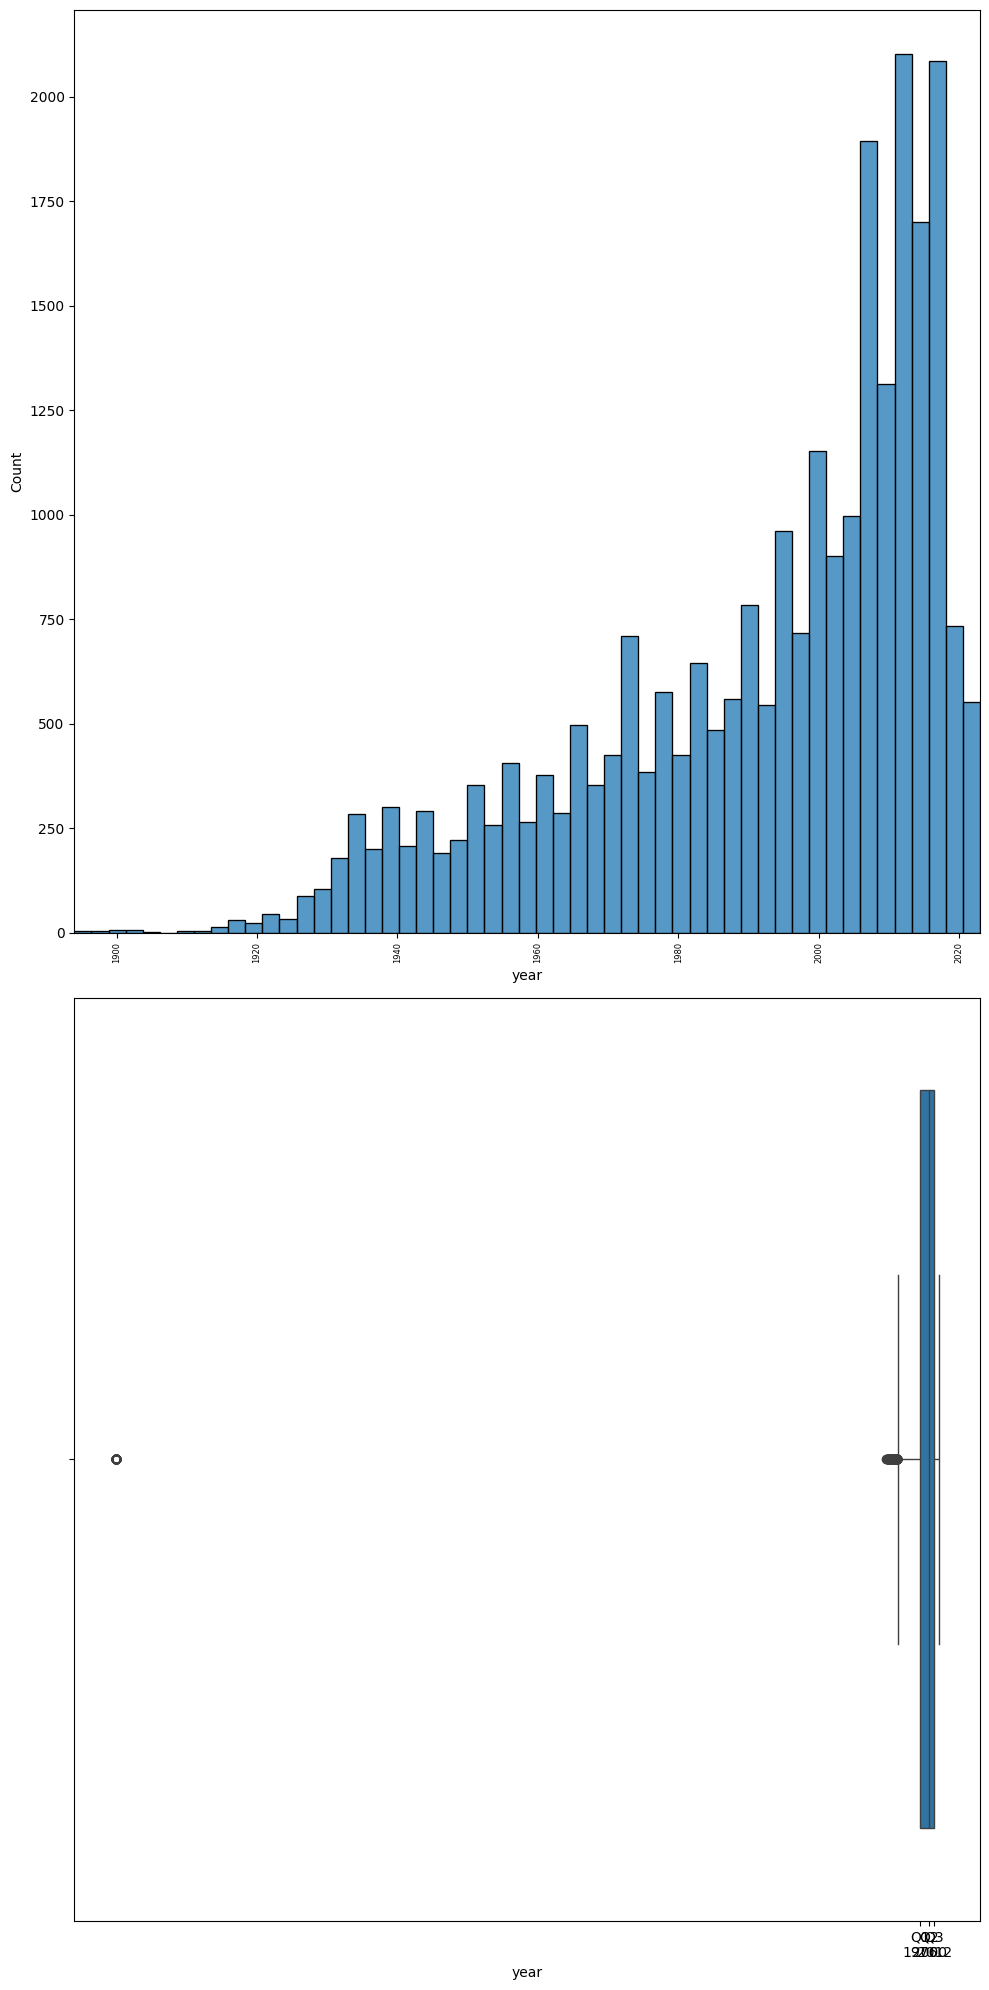

In [28]:
fig, axis = plt.subplots(2, 1, figsize = (10, 20))

sns.histplot(
    ax=axis[0], 
    data=movies[movies["year"] != 0],  # filtrar year != 0
    x="year"
)
axis[0].set_xlim(movies[movies["year"] != 0]["year"].min(), 
                 movies[movies["year"] != 0]["year"].max())
axis[0].tick_params(axis='x', rotation=90, labelsize=6)

# Boxplot
sns.boxplot(ax=axis[1], data=movies, x="year")

# Obtener cuartiles de los datos
q1, q2, q3 = np.percentile(movies[movies["year"] > 1800]["year"], [25, 50, 75])

# Mostrar solo cuartiles en el eje X
axis[1].set_xticks([q1, q2, q3])
axis[1].set_xticklabels([f"Q1\n{int(q1)}", f"Q2\n{int(q2)}", f"Q3\n{int(q3)}"])

plt.tight_layout()
plt.show()

### Variables Categóricas

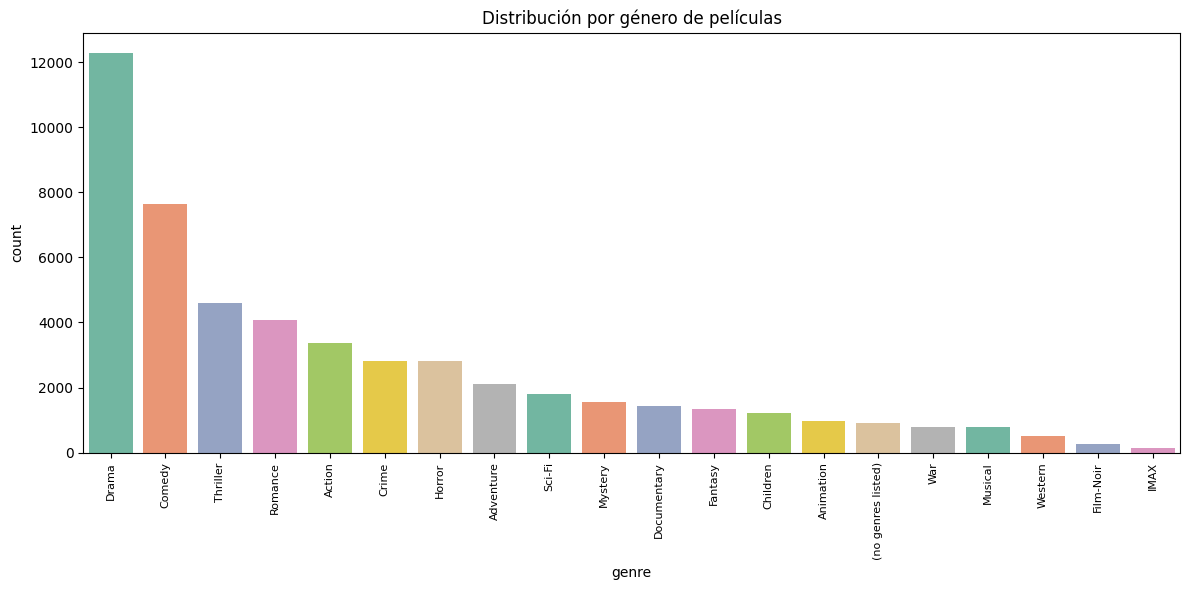

In [29]:
#Genres
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=movie_genre,
    x="genre",
    order=movie_genre["genre"].value_counts().index,
    palette="Set2"
)

plt.title("Distribución por género de películas")
ax.tick_params(axis='x', rotation=90, labelsize=8)
plt.tight_layout()
plt.show()

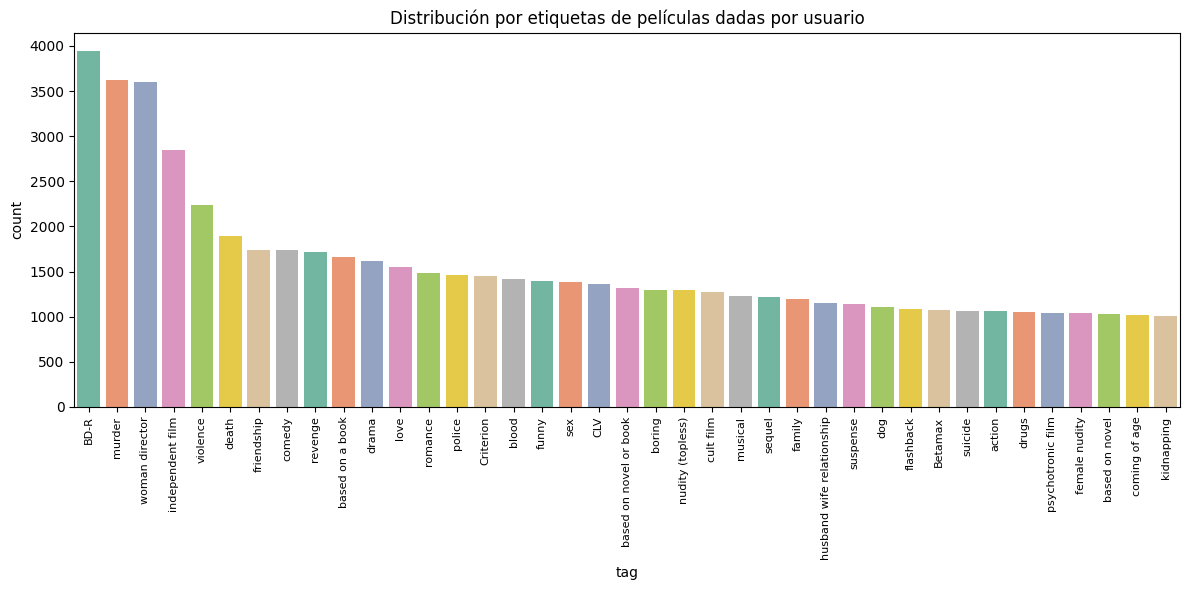

In [30]:
#Tags
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=movie_tag,
    x="tag",
    order=movie_tag["tag"].value_counts().index,
    palette="Set2"
)

plt.title("Distribución por etiquetas de películas dadas por usuario")
ax.tick_params(axis='x', rotation=90, labelsize=8)
plt.tight_layout()
plt.show()

## Análisis Multivariante

## Análisis de Correlación Múltiple

# Combinamos Datasets

Para simplificar el problema, trabajaremos con un único género y combinaremos los datasets analizados previamente. El género elegido es *Drama*.

## Filtramos las películas del género Drama

In [31]:
drama_movies = movie_genre[movie_genre["genre"] == "Drama"]

drama_movies.head()

,movieId,title,genre,year
11,4,Waiting to Exhale (1995),Drama,1995
26,11,"American President, The (1995)",Drama,1995
33,14,Nixon (1995),Drama,1995
38,16,Casino (1995),Drama,1995
39,17,Sense and Sensibility (1995),Drama,1995


## Agregamos el rating al dataset

In [32]:
drama_movies = drama_movies.merge(
    movie_rating, 
    on="movieId",
    how="left"
)

drama_movies.head()

,movieId,title,genre,year,avg_rating,num_ratings
0,4,Waiting to Exhale (1995),Drama,1995,2.845331,2806.0
1,11,"American President, The (1995)",Drama,1995,3.657160,19127.0
2,14,Nixon (1995),Drama,1995,3.428303,6116.0
3,16,Casino (1995),Drama,1995,3.838349,22298.0
4,17,Sense and Sensibility (1995),Drama,1995,3.945126,22251.0


In [33]:
drama_movies[drama_movies["movieId"] == 7283]

,movieId,title,genre,year,avg_rating,num_ratings
2584,7283,Swing Shift (1984),Drama,1984,2.918919,148.0


In [38]:
movies[movies["movieId"] == 212098]

,movieId,title,genres,year


In [39]:
reviews = pd.read_csv("../data/processed/reviews_clean.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/reviews_clean.csv'

In [ ]:
movies_reviews = drama_movies.merge(
    movie_rating, 
    on="movieId",
    how="left"
)

drama_movies.head()